In [220]:
import pyodbc
import pandas as pd
from sqlalchemy import create_engine
import numpy as np

In [247]:
# Step 1: Connect to SQL Server database

connection_string = (
    "mssql+pyodbc://@localhost/ecommerce_db"
    "?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
)


engine = create_engine(connection_string)

In [248]:
x = pd.read_sql("SELECT TOP 5 p.name, SUM(od.quantity) AS total_quantity_sold FROM order_details od JOIN products p ON od.product_id = p.id GROUP BY p.name ORDER BY total_quantity_sold DESC;", engine) 
x

,name,total_quantity_sold
0,Devolved grid-enabled application,288
1,Vision-oriented scalable archive,253
2,Versatile holistic help-desk,252
3,Up-sized interactive time-frame,245
4,Vision-oriented 3rdgeneration data-warehouse,242


In [249]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from datetime import timedelta
from prophet import Prophet
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [250]:
# Step 1: Connect to SQL Server database
server = 'localhost'
database = 'ecommerce_db'

connection_string = (
    "mssql+pyodbc://@localhost/ecommerce_db"
    "?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
)
engine = create_engine(connection_string)

query = "SELECT TOP 10 * FROM orders"

try:
    df = pd.read_sql(query, engine)
    print(df.head())
except Exception as e:
    print("Error:", e)


   id  customer_id          order_date  total_amount      status
0   1           13 2025-04-05 09:06:50        521.85     shipped
1   2           15 2025-03-05 08:27:50        436.91  processing
2   3            9 2025-04-21 21:19:19       7711.55   cancelled
3   4           19 2025-04-15 02:16:41       7952.82   cancelled
4   5           31 2025-02-11 17:30:12       2785.65   cancelled


In [251]:
# Step 2: Load sales data
query = """
SELECT
    o.order_date,
    od.product_id,
    od.quantity,
    od.unit_price,
    (od.quantity * od.unit_price) AS revenue
FROM orders o
JOIN order_details od ON o.id = od.order_id
WHERE o.order_date IS NOT NULL
ORDER BY o.order_date
"""

df = pd.read_sql(query, engine)
df['order_date'] = pd.to_datetime(df['order_date'])

In [252]:
df

,order_date,product_id,quantity,unit_price,revenue
0,2025-01-01 00:03:42,251,3,356.44,1069.32
1,2025-01-01 00:03:42,431,1,205.05,205.05
2,2025-01-01 00:20:43,339,3,47.83,143.49
3,2025-01-01 00:20:43,579,4,371.73,1486.92
4,2025-01-01 00:20:43,147,1,663.91,663.91
...,...,...,...,...,...
30663,2025-05-07 23:18:15,513,4,833.27,3333.08
30664,2025-05-07 23:18:15,232,4,386.66,1546.64
30665,2025-05-07 23:18:15,525,4,933.87,3735.48
30666,2025-05-07 23:18:15,189,1,844.60,844.60


In [253]:
df.isnull().sum().sum()

0

In [254]:
df.duplicated().sum()

17

In [255]:
df.drop_duplicates(inplace=True)

In [271]:
# Step 2 & 3: Preprocessing and aggregation
# For forecasting, we aggregate revenue daily
daily_sales = df.groupby('order_date').agg({'revenue': 'sum'}).reset_index()

# Feature Engineering: Extract date features
daily_sales['day'] = daily_sales['order_date'].dt.day
daily_sales['month'] = daily_sales['order_date'].dt.month
daily_sales['year'] = daily_sales['order_date'].dt.year
daily_sales['dayofweek'] = daily_sales['order_date'].dt.dayofweek
daily_sales['weekofyear'] = daily_sales['order_date'].dt.isocalendar().week.astype(int)

# Optionally add lag features to help the model learn trends
for lag in [1, 7, 14]:
    daily_sales[f'revenue_lag_{lag}'] = daily_sales['revenue'].shift(lag)

daily_sales.dropna(inplace=True)  # drop rows with NaN caused by lag features

In [272]:
daily_sales.head()

,order_date,revenue,day,month,year,dayofweek,weekofyear,revenue_lag_1,revenue_lag_7,revenue_lag_14
14,2025-01-01 03:23:46,5042.67,1,1,2025,2,1,7661.85,5399.28,1274.37
15,2025-01-01 03:56:51,5955.35,1,1,2025,2,1,5042.67,3476.49,6220.98
16,2025-01-01 04:23:06,4212.76,1,1,2025,2,1,5955.35,6834.60,5840.58
17,2025-01-01 04:28:19,7057.49,1,1,2025,2,1,4212.76,6068.12,6801.20
18,2025-01-01 04:52:36,9036.64,1,1,2025,2,1,7057.49,4788.96,263.16


In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import IsolationForest


# 1. Summarize statistics
print("Summary statistics for revenue:")
print(daily_sales['revenue'].describe())

print("\nStandard deviation of revenue:", daily_sales['revenue'].std())



Summary statistics for revenue:
count    10183.000000
mean      4405.742090
std       2902.558855
min         11.410000
25%       2080.150000
50%       4024.100000
75%       6277.375000
max      16939.310000
Name: revenue, dtype: float64

Standard deviation of revenue: 2902.558854603891


In [294]:
# Step 4: Prepare features and target
X = daily_sales.drop(columns=['order_date', 'revenue'])
y = daily_sales['revenue']
#y = np.log1p(daily_sales['revenue'])

In [295]:
# Step 5: Train/test split (e.g., last 20% as test)
split_index = int(len(daily_sales) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [296]:
# Step 6: Train model
# model = GradientBoostingRegressor(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    random_state=42
)
model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=6, n_estimators=500,
                          random_state=42, subsample=0.8)

In [288]:
# Step 7: Evaluate model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAPE: {mape:.2%}")

Test RMSE: 0.97
Test MAPE: 10.22%


In [297]:
# Step 8: Predict future sales (example: next 7 days)
# Create future dataframe with date features for next 7 days
last_date = daily_sales['order_date'].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=7)

future_df = pd.DataFrame({'order_date': future_dates})
future_df['day'] = future_df['order_date'].dt.day
future_df['month'] = future_df['order_date'].dt.month
future_df['year'] = future_df['order_date'].dt.year
future_df['dayofweek'] = future_df['order_date'].dt.dayofweek
future_df['weekofyear'] = future_df['order_date'].dt.isocalendar().week.astype(int)

# Add lag features based on last known data (using last rows of daily_sales)
for lag in [1, 7, 14]:
    future_df[f'revenue_lag_{lag}'] = daily_sales['revenue'].iloc[-lag]

# Add rolling features from historical data
future_df['rolling_mean_7'] = daily_sales['revenue'].rolling(window=7).mean().iloc[-1]
future_df['rolling_std_7'] = daily_sales['revenue'].rolling(window=7).std().iloc[-1]

# Predict
future_predictions = model.predict(future_df.drop(columns=['order_date']))
print("Future 7 days sales predictions:")
print(pd.DataFrame({'date': future_dates, 'predicted_revenue': future_predictions}))

Future 7 days sales predictions:
                 date  predicted_revenue
0 2025-05-08 23:18:15        4155.608706
1 2025-05-09 23:18:15        4131.639934
2 2025-05-10 23:18:15        4105.476919
3 2025-05-11 23:18:15        4097.911845
4 2025-05-12 23:18:15        3934.684912
5 2025-05-13 23:18:15        3975.499431
6 2025-05-14 23:18:15        4084.872259


In [298]:
# ======================================================
# Step 8A: Forecast Future Weeks, Months, Years
# ======================================================
def prepare_future_features(start_date, end_date, base_df):
    dates = pd.date_range(start=start_date, end=end_date)
    df = pd.DataFrame({'order_date': dates})
    df['day'] = df['order_date'].dt.day
    df['month'] = df['order_date'].dt.month
    df['year'] = df['order_date'].dt.year
    df['dayofweek'] = df['order_date'].dt.dayofweek
    df['weekofyear'] = df['order_date'].dt.isocalendar().week.astype(int)
    
    for lag in [1, 7, 14]:
        df[f'revenue_lag_{lag}'] = base_df['revenue'].iloc[-lag]
    df['rolling_mean_7'] = base_df['revenue'].rolling(window=7).mean().iloc[-1]
    df['rolling_std_7'] = base_df['revenue'].rolling(window=7).std().iloc[-1]
    return df

# --- Weekly Forecast (3 weeks)
future_weeks = prepare_future_features(
    start_date=last_date + timedelta(days=1),
    end_date=last_date + timedelta(days=21),
    base_df=daily_sales
)
future_weeks['predicted_revenue'] = model.predict(future_weeks.drop(columns=['order_date']))
weekly_forecast = future_weeks.groupby(pd.Grouper(key='order_date', freq='W-MON')).sum(numeric_only=True).reset_index()
print("\n📅 Weekly Forecast (Next 3 Weeks):")
print(weekly_forecast[['order_date', 'predicted_revenue']])

# --- Monthly Forecast (3 months)
future_months = prepare_future_features(
    start_date=last_date + timedelta(days=1),
    end_date=last_date + pd.DateOffset(months=3),
    base_df=daily_sales
)
future_months['predicted_revenue'] = model.predict(future_months.drop(columns=['order_date']))
monthly_forecast = future_months.groupby(pd.Grouper(key='order_date', freq='MS')).sum(numeric_only=True).reset_index()
print("\n📅 Monthly Forecast (Next 3 Months):")
print(monthly_forecast[['order_date', 'predicted_revenue']])

# --- Yearly Forecast (3 years)
future_years = prepare_future_features(
    start_date=last_date + timedelta(days=1),
    end_date=last_date + pd.DateOffset(years=3),
    base_df=daily_sales
)
future_years['predicted_revenue'] = model.predict(future_years.drop(columns=['order_date']))
yearly_forecast = future_years.groupby(pd.Grouper(key='order_date', freq='YS')).sum(numeric_only=True).reset_index()
print("\n📅 Yearly Forecast (Next 3 Years):")
print(yearly_forecast[['order_date', 'predicted_revenue']])

# =====================================
# Step 8: Save the Model
# =====================================
joblib.dump(model, "sales_forecast_model.joblib")
print("\n✅ Model saved as 'sales_forecast_model.joblib'")


📅 Weekly Forecast (Next 3 Weeks):
  order_date  predicted_revenue
0 2025-05-12       20425.322315
1 2025-05-19       29212.045344
2 2025-05-26       29112.509318
3 2025-06-02        7952.205386

📅 Monthly Forecast (Next 3 Months):
  order_date  predicted_revenue
0 2025-05-01       99176.786845
1 2025-06-01      122485.821936
2 2025-07-01      126593.548650
3 2025-08-01       27843.510790

📅 Yearly Forecast (Next 3 Years):
  order_date  predicted_revenue
0 2025-01-01       9.736361e+05
1 2026-01-01       1.491533e+06
2 2027-01-01       1.491532e+06
3 2028-01-01       5.222925e+05

✅ Model saved as 'sales_forecast_model.joblib'


In [299]:
import plotly.express as px
import plotly.graph_objects as go


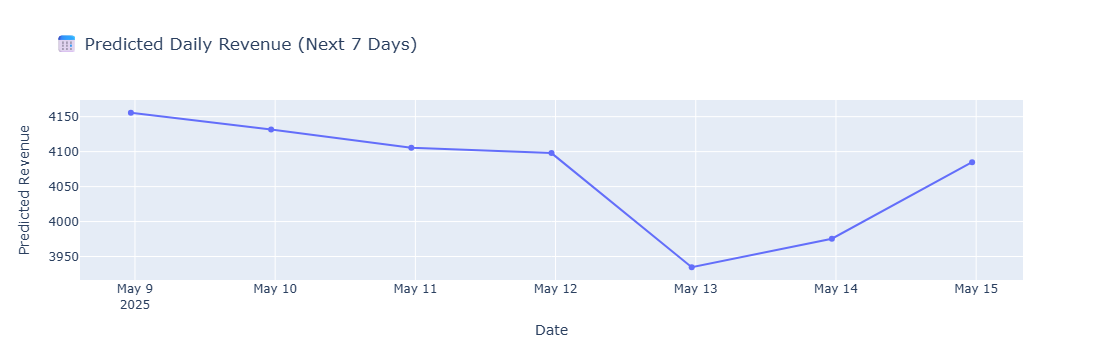

In [300]:
fig_daily = px.line(
    forecast_result,
    x='date',
    y='predicted_revenue',
    title='📅 Predicted Daily Revenue (Next 7 Days)',
    markers=True
)
fig_daily.update_layout(xaxis_title='Date', yaxis_title='Predicted Revenue')
fig_daily.show()


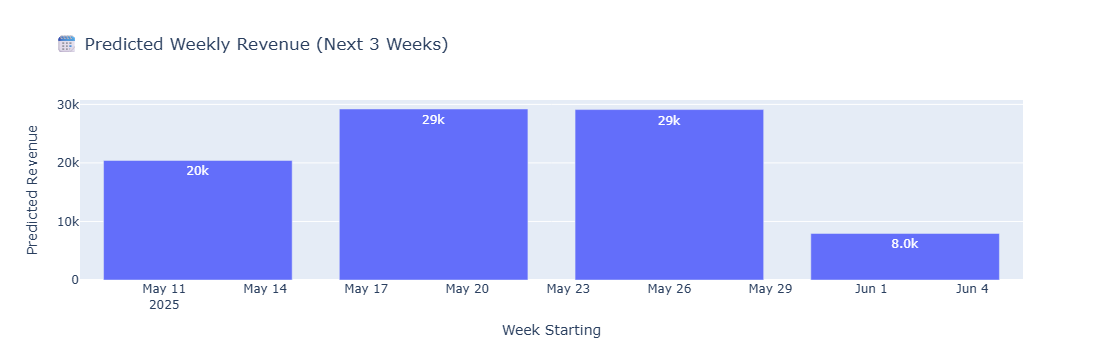

In [301]:
fig_weekly = px.bar(
    weekly_forecast,
    x='order_date',
    y='predicted_revenue',
    title='🗓️ Predicted Weekly Revenue (Next 3 Weeks)',
    text_auto='.2s'
)
fig_weekly.update_layout(xaxis_title='Week Starting', yaxis_title='Predicted Revenue')
fig_weekly.show()


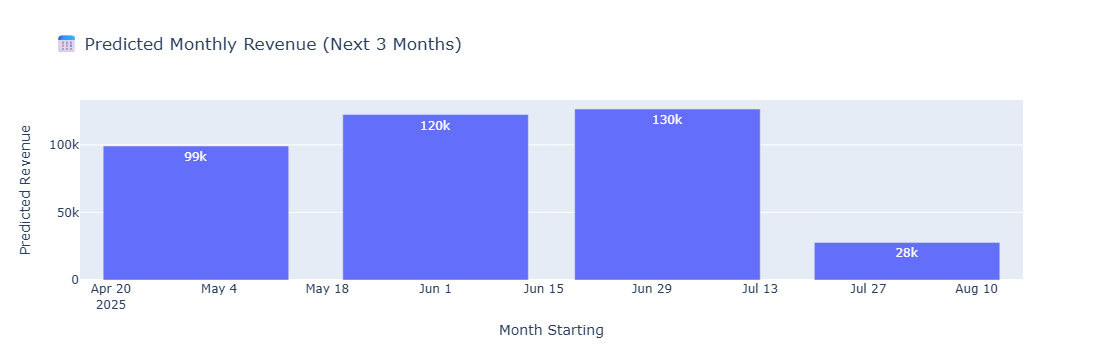

In [302]:
fig_monthly = px.bar(
    monthly_forecast,
    x='order_date',
    y='predicted_revenue',
    title='📅 Predicted Monthly Revenue (Next 3 Months)',
    text_auto='.2s'
)
fig_monthly.update_layout(xaxis_title='Month Starting', yaxis_title='Predicted Revenue')
fig_monthly.show()


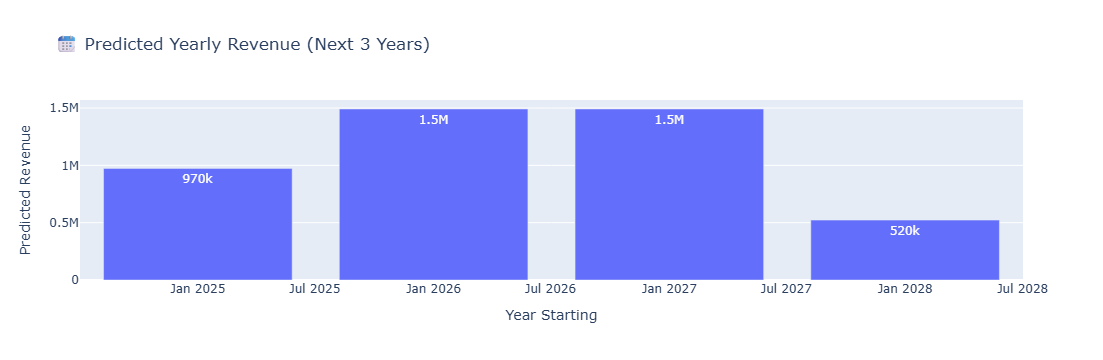

In [303]:
fig_yearly = px.bar(
    yearly_forecast,
    x='order_date',
    y='predicted_revenue',
    title='📆 Predicted Yearly Revenue (Next 3 Years)',
    text_auto='.2s'
)
fig_yearly.update_layout(xaxis_title='Year Starting', yaxis_title='Predicted Revenue')
fig_yearly.show()
